In [52]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vehicle-sales-data/car_prices.csv


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!
XGBoost version: 3.1.0


In [ ]:
df = pd.read_csv('/kaggle/input/vehicle-sales-data/car_prices.csv')

print("DATASET OVERVIEW")
print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nBasic statistics:")
print(df.describe())


DATASET OVERVIEW
Dataset shape: (558837, 16)

First few rows:
   year   make                model        trim   body transmission  \
0  2015    Kia              Sorento          LX    SUV    automatic   
1  2015    Kia              Sorento          LX    SUV    automatic   
2  2014    BMW             3 Series  328i SULEV  Sedan    automatic   
3  2015  Volvo                  S60          T5  Sedan    automatic   
4  2014    BMW  6 Series Gran Coupe        650i  Sedan    automatic   

                 vin state  condition  odometer  color interior  \
0  5xyktca69fg566472    ca        5.0   16639.0  white    black   
1  5xyktca69fg561319    ca        5.0    9393.0  white    beige   
2  wba3c1c51ek116351    ca       45.0    1331.0   gray    black   
3  yv1612tb4f1310987    ca       41.0   14282.0  white    black   
4  wba6b2c57ed129731    ca       43.0    2641.0   gray    black   

                                   seller      mmr  sellingprice  \
0                 kia motors america  i

In [ ]:

print("OUTLIER FILTERING")

original_size = len(df)

df_filtered = df[
    (df['year'] >= 1990) &
    (df['year'] <= 2026) &
    (df['odometer'] > 0) &
    (df['odometer'] <= 500000) &
    (df['sellingprice'] > 500) &
    (df['sellingprice'] <= 150000) &
    (df['condition'] >= 1) &
    (df['condition'] <= 49)
].copy()

Q1 = df_filtered['sellingprice'].quantile(0.01)
Q3 = df_filtered['sellingprice'].quantile(0.99)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df_filtered[
    (df_filtered['sellingprice'] >= lower_bound) &
    (df_filtered['sellingprice'] <= upper_bound)
]

print(f"Original dataset: {original_size:,} rows")
print(f"After filtering: {len(df_filtered):,} rows")
print(f"Removed: {original_size - len(df_filtered):,} rows ({100*(original_size - len(df_filtered))/original_size:.2f}%)")



OUTLIER FILTERING
Original dataset: 558,837 rows
After filtering: 540,161 rows
Removed: 18,676 rows (3.34%)


In [ ]:
print("STRATIFIED SAMPLING")

target_size = min(100000, int(len(df_filtered) * 0.2))

df_filtered['year_bin'] = pd.cut(df_filtered['year'], bins=10, labels=False)
df_filtered['price_bin'] = pd.qcut(df_filtered['sellingprice'], q=10, labels=False, duplicates='drop')

df_sample = df_filtered.groupby(['year_bin', 'price_bin'], group_keys=False).apply(
    lambda x: x.sample(min(len(x), max(1, int(len(x) * target_size / len(df_filtered)))), random_state=RANDOM_STATE)
).reset_index(drop=True)

df_sample = df_sample.drop(['year_bin', 'price_bin'], axis=1)

print(f"Target sample size: {target_size:,}")
print(f"Actual sample size: {len(df_sample):,}")
print(f"Sampling ratio: {100*len(df_sample)/len(df_filtered):.2f}%")

print("\nYear distribution comparison:")
print("Original:")
print(df_filtered['year'].value_counts(bins=5, sort=False).head())
print("\nSampled:")
print(df_sample['year'].value_counts(bins=5, sort=False).head())


STRATIFIED SAMPLING
Target sample size: 100,000
Actual sample size: 99,970
Sampling ratio: 18.51%

Year distribution comparison:
Original:
(1989.974, 1995.0]       690
(1995.0, 2000.0]        9158
(2000.0, 2005.0]       60930
(2005.0, 2010.0]      131733
(2010.0, 2015.0]      337650
Name: count, dtype: int64

Sampled:
(1989.974, 1995.0]      129
(1995.0, 2000.0]       1693
(2000.0, 2005.0]      11270
(2005.0, 2010.0]      24379
(2010.0, 2015.0]      62499
Name: count, dtype: int64


In [ ]:
print("DATA CLEANING AND STANDARDIZATION")

df_sample['make'] = df_sample['make'].fillna('Unknown')
df_sample['model'] = df_sample['model'].fillna('Unknown')
df_sample['body'] = df_sample['body'].fillna('Unknown')
df_sample['transmission'] = df_sample['transmission'].fillna('unknown')

df_sample['make'] = df_sample['make'].astype(str).str.strip().str.title()
print(f"Unique makes after cleaning: {df_sample['make'].nunique()}")

df_sample['model'] = df_sample['model'].astype(str).str.strip().str.title()
print(f"Unique models after cleaning: {df_sample['model'].nunique()}")

def standardize_body_type(body):
    """Standardize body type classifications"""
    if pd.isna(body):
        return 'Other'
    
    body = str(body).lower().strip()
    
    if 'coupe' in body or 'cpe' in body:
        return 'Coupe'
    
    if 'sedan' in body or 'sdn' in body:
        return 'Sedan'
    
    if 'suv' in body or 'sport utility' in body:
        return 'SUV'
    
    if 'truck' in body or 'pickup' in body:
        return 'Truck'
    
    if 'van' in body or 'minivan' in body:
        return 'Van'
    
    if 'wagon' in body or 'wgn' in body:
        return 'Wagon'
    
    if 'convertible' in body or 'conv' in body or 'cabriolet' in body:
        return 'Convertible'
    
    if 'hatchback' in body or 'hatch' in body:
        return 'Hatchback'
    
    return 'Other'

df_sample['body'] = df_sample['body'].apply(standardize_body_type)
print(f"\nBody types after standardization:")
print(df_sample['body'].value_counts())

df_sample['transmission'] = df_sample['transmission'].astype(str).str.strip().str.lower()

print(f"\nMissing values after cleaning:")
print(df_sample.isnull().sum())

print(f"\nData cleaning summary:")
print(f"  - Makes standardized: {df_sample['make'].nunique()} unique brands")
print(f"  - Models standardized: {df_sample['model'].nunique()} unique models")
print(f"  - Body types reduced to standard categories")
print(f"  - Transmission values normalized")



DATA CLEANING AND STANDARDIZATION
Unique makes after cleaning: 55
Unique models after cleaning: 706

Body types after standardization:
body
Sedan          44532
SUV            25717
Other          10814
Van             5762
Hatchback       4713
Coupe           3517
Wagon           2916
Convertible     1999
Name: count, dtype: int64

Missing values after cleaning:
year               0
make               0
model              0
trim            1779
body               0
transmission       0
vin                0
state              0
condition          0
odometer           0
color            125
interior         125
seller             0
mmr                0
sellingprice       0
saledate           0
dtype: int64

Data cleaning summary:
  - Makes standardized: 55 unique brands
  - Models standardized: 706 unique models
  - Body types reduced to standard categories
  - Transmission values normalized


In [ ]:
print("ENCODING CATEGORICAL VARIABLES")

categorical_cols = ['make', 'model', 'body', 'transmission']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_sample[f'{col}_encoded'] = le.fit_transform(df_sample[col].astype(str))
    label_encoders[col] = le
    print(f"{col}: {len(le.classes_)} unique values")


ENCODING CATEGORICAL VARIABLES
make: 55 unique values
model: 706 unique values
body: 8 unique values
transmission: 3 unique values


In [ ]:
print("PREPARING FEATURES AND TARGET")

feature_cols = [
    'year', 'condition', 'odometer',
    'make_encoded', 'model_encoded', 'body_encoded', 'transmission_encoded'
]

X = df_sample[feature_cols]
y = df_sample['sellingprice']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures used:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")


PREPARING FEATURES AND TARGET
Features shape: (99970, 7)
Target shape: (99970,)

Features used:
  1. year
  2. condition
  3. odometer
  4. make_encoded
  5. model_encoded
  6. body_encoded
  7. transmission_encoded


In [ ]:
print("TRAIN-TEST SPLIT")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Split ratio: 80/20")


TRAIN-TEST SPLIT
Training set: 79,976 samples
Test set: 19,994 samples
Split ratio: 80/20


In [ ]:
print("XGBOOST MODEL TRAINING")

params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'eval_metric': 'rmse'
}

print("Model parameters:")
for key, value in params.items():
    print(f"  {key}: {value}")

print("\nTraining XGBoost model...")
try:
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    print("Training completed successfully!")
except Exception as e:
    print(f"Error during training: {e}")
    raise


XGBOOST MODEL TRAINING
Model parameters:
  objective: reg:squarederror
  max_depth: 6
  learning_rate: 0.1
  n_estimators: 200
  subsample: 0.8
  colsample_bytree: 0.8
  random_state: 42
  n_jobs: -1
  eval_metric: rmse

Training XGBoost model...
Training completed successfully!


In [ ]:
print("MODEL EVALUATION")

if 'model' not in locals():
    raise NameError("Model not found!")

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

print("\nPERFORMANCE METRICS:")
print("-" * 50)
print(f"{'Metric':<20} {'Training':<15} {'Test':<15}")
print("-" * 50)
print(f"{'R² Score':<20} {train_r2:<15.4f} {test_r2:<15.4f}")
print(f"{'MAE ($)':<20} {train_mae:<15.2f} {test_mae:<15.2f}")
print(f"{'RMSE ($)':<20} {train_rmse:<15.2f} {test_rmse:<15.2f}")
print(f"{'MAPE (%)':<20} {train_mape:<15.2f} {test_mape:<15.2f}")
print("-" * 50)

print("\nPerforming 5 fold cross validation...")
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print(f"CV R² scores: {cv_scores}")
print(f"Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


MODEL EVALUATION

PERFORMANCE METRICS:
--------------------------------------------------
Metric               Training        Test           
--------------------------------------------------
R² Score             0.9044          0.8928         
MAE ($)              1865.20         1952.31        
RMSE ($)             2953.20         3085.00        
MAPE (%)             19.70           20.16          
--------------------------------------------------

Performing 5-fold cross-validation...
CV R² scores: [0.88782818 0.89105679 0.88614266 0.88251455 0.88663801]
Mean CV R²: 0.8868 (+/- 0.0055)



FEATURE IMPORTANCE ANALYSIS

Feature Importance Ranking:
----------------------------------------
year                      0.2488
body_encoded              0.2061
odometer                  0.1948
make_encoded              0.1559
model_encoded             0.0995
condition                 0.0843
transmission_encoded      0.0105

Feature importance plot saved as 'feature_importance.png'


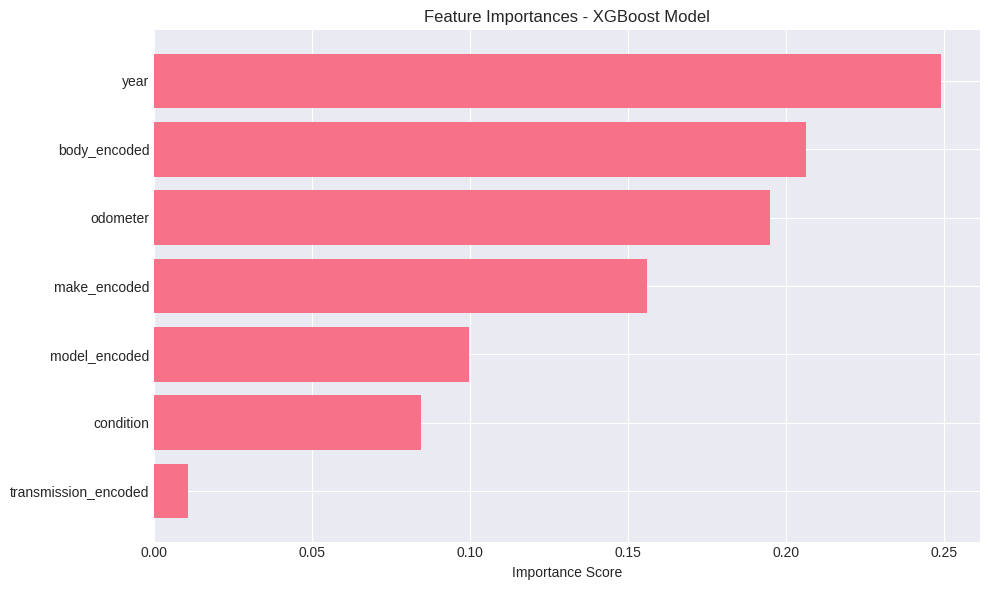

In [ ]:
print("FEATURE IMPORTANCE ANALYSIS")

importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance Ranking:")
print("-" * 40)
for idx, row in importance_df.iterrows():
    print(f"{row['feature']:<25} {row['importance']:.4f}")

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importances - XGBoost Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
print("SAVING MODEL AND ENCODERS")

joblib.dump(model, 'vehicle_price_model.pkl')
print("Model saved as 'vehicle_price_model.pkl'")

joblib.dump(label_encoders, 'label_encoders.pkl')
print("Label encoders saved as 'label_encoders.pkl'")

joblib.dump(feature_cols, 'feature_columns.pkl')
print("Feature columns saved as 'feature_columns.pkl'")

make_model_mapping = {}
for make in df_sample['make'].unique():
    models = df_sample[df_sample['make'] == make]['model'].dropna().unique()
    
    models = sorted([str(m) for m in models])
    if models:  
        make_model_mapping[make] = models

joblib.dump(make_model_mapping, 'make_model_mapping.pkl')
print("Make-model mapping saved as 'make_model_mapping.pkl'")

statistics = {
    'train_size': len(X_train),
    'test_size': len(X_test),
   
    'ml_r2_score': test_r2,
    'ml_mae': test_mae,
    'ml_rmse': test_rmse,
    'ml_mape': test_mape,
}
joblib.dump(statistics, 'model_statistics.pkl')
print("Model statistics saved as 'model_statistics.pkl'")


SAVING MODEL AND ENCODERS
Model saved as 'vehicle_price_model.pkl'
Label encoders saved as 'label_encoders.pkl'
Feature columns saved as 'feature_columns.pkl'
Make-model mapping saved as 'make_model_mapping.pkl'
Model statistics saved as 'model_statistics.pkl'


In [ ]:

class VehiclePricingRules:
    """Expert rule-based system for vehicle pricing"""
    
    def __init__(self):
        self.rules_applied = []
        self.warnings = []
    
    def reset(self):
        self.rules_applied = []
        self.warnings = []
    
    def adjust_prediction(self, base_prediction, vehicle_data):
        """Apply expert rules to adjust ML model prediction"""
        adjusted_price = base_prediction
        adjustments = []
        
        year = vehicle_data.get('year')
        odometer = vehicle_data.get('odometer')
        condition = vehicle_data.get('condition')
        make = vehicle_data.get('make', '')
        model = vehicle_data.get('model', '')
        body = vehicle_data.get('body', '')
        transmission = vehicle_data.get('transmission', '')
        
        luxury_brands = ['Bmw', 'Mercedes-Benz', 'Audi', 'Lexus', 'Porsche', 'Tesla']
        if make in luxury_brands and year:
            vehicle_age = 2026 - year
            if vehicle_age > 9:
                depreciation_factor = 1 - (vehicle_age - 9) * 0.01
                adjustment = adjusted_price * (depreciation_factor - 1)
                adjusted_price *= depreciation_factor
                adjustments.append(('Luxury depreciation', adjustment))
        
        popular_trucks = ['F-150', 'Silverado', 'Ram', 'Tundra', 'Tacoma']
        if body == 'Truck' and any(truck in model for truck in popular_trucks):
            premium = base_prediction * 0.01
            adjusted_price += premium
            adjustments.append(('Popular truck premium', premium))
        
        if odometer and odometer > 190000:
            penalty_rate = min((odometer - 190000) / 100000 * 0.029, 0.1)
            penalty = base_prediction * penalty_rate
            adjusted_price -= penalty
            adjustments.append(('High mileage penalty', -penalty))
        
        if condition and condition >= 47:
            bonus = base_prediction * 0.035
            adjusted_price += bonus
            adjustments.append(('Excellent condition bonus', bonus))
        
        elif condition and condition <= 10:
            penalty = base_prediction * 0.08
            adjusted_price -= penalty
            adjustments.append(('Poor condition penalty', -penalty))
        
        if odometer and year:
            vehicle_age = 2026 - year
            expected_mileage = vehicle_age * 14000
            if odometer < expected_mileage * 0.15 and vehicle_age > 2:
                premium = base_prediction * 0.028
                adjusted_price += premium
                adjustments.append(('Low mileage premium', premium))
        
        adjusted_price = max(adjusted_price, 180)
        
        return {
            'adjusted_price': adjusted_price,
            'base_price': base_prediction,
            'adjustments': adjustments,
            'total_adjustment': adjusted_price - base_prediction
        }

rules_engine = VehiclePricingRules()


RULE-BASED SYSTEM INTEGRATION
Rule-based system initialized successfully!



HYBRID SYSTEM EVALUATION (ML + Rules)

Applying rule-based adjustments to test set...

HYBRID SYSTEM PERFORMANCE:
Metric               ML Only         Hybrid (ML+Rules)    Improvement    
----------------------------------------------------------------------
R² Score             0.8928          0.8871               -0.57%
MAE ($)              1952.31         2005.92              -53.61
RMSE ($)             3085.00         3165.64              -80.64
MAPE (%)             20.16           19.91                +0.25%

RULE ADJUSTMENT STATISTICS:
--------------------------------------------------
Average adjustment: $-62.83
Median adjustment: $+0.00
Max positive adjustment: $+4,236.08
Max negative adjustment: $-5,782.21
% predictions adjusted: 44.1%

Hybrid system analysis plot saved as 'hybrid_system_analysis.png'


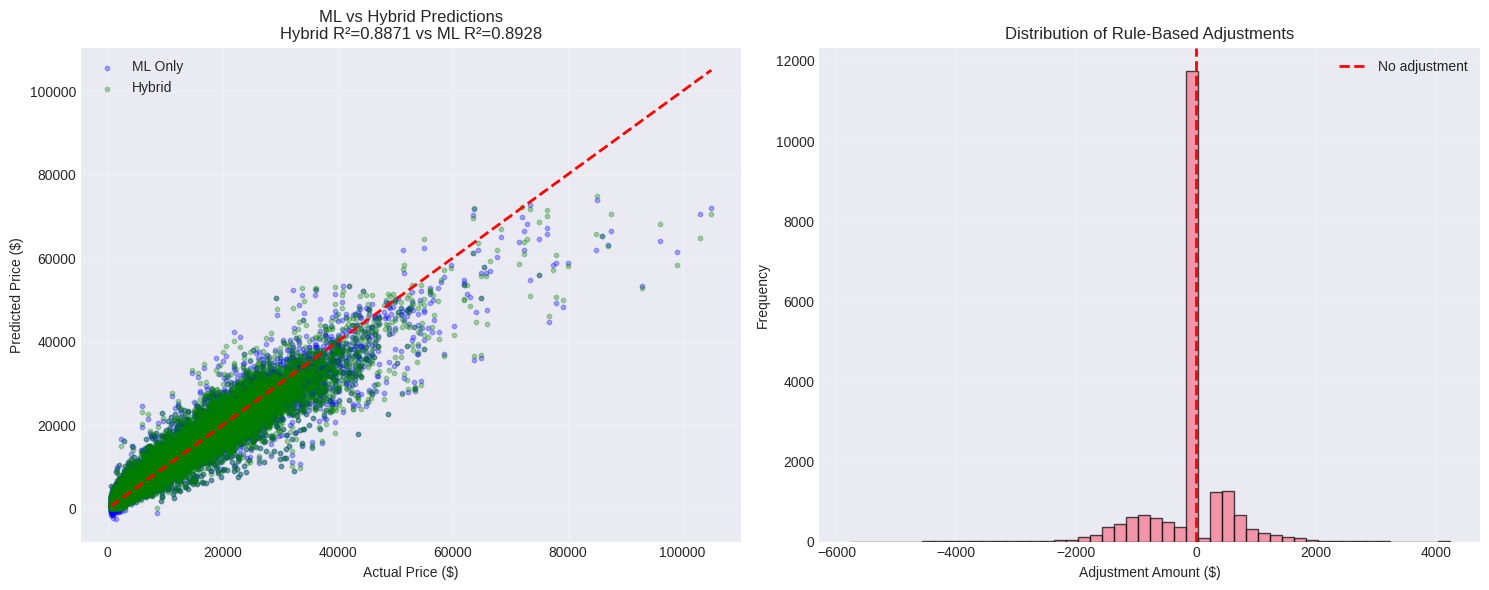

In [ ]:
print("HYBRID SYSTEM EVALUATION (ML + Rules)")

if 'y_test_pred' not in locals():
    print("ERROR: Test predictions not found. Skipping hybrid evaluation.")
    print("Please ensure Part 10 (Model Evaluation) ran successfully.")
    hybrid_r2 = test_r2
    hybrid_mae = test_mae
    hybrid_rmse = test_rmse
    hybrid_mape = test_mape
    rule_adjustments_list = np.zeros(len(y_test))
else:
    print("\nApplying rule-based adjustments to test set...")
    hybrid_predictions = []
    rule_adjustments_list = []

    for idx in range(len(y_test)):
        ml_pred = y_test_pred[idx]
        
        test_idx = X_test.index[idx]
        vehicle_data = {
            'year': X_test.iloc[idx]['year'],
            'make': df_sample.loc[test_idx, 'make'],
            'model': df_sample.loc[test_idx, 'model'],
            'body': df_sample.loc[test_idx, 'body'],
            'transmission': df_sample.loc[test_idx, 'transmission'],
            'condition': X_test.iloc[idx]['condition'],
            'odometer': X_test.iloc[idx]['odometer']
        }
        
        result = rules_engine.adjust_prediction(ml_pred, vehicle_data)
        hybrid_predictions.append(result['adjusted_price'])
        rule_adjustments_list.append(result['total_adjustment'])

    hybrid_predictions = np.array(hybrid_predictions)
    rule_adjustments_list = np.array(rule_adjustments_list)

    hybrid_r2 = r2_score(y_test, hybrid_predictions)
    hybrid_mae = mean_absolute_error(y_test, hybrid_predictions)
    hybrid_rmse = np.sqrt(mean_squared_error(y_test, hybrid_predictions))
    hybrid_mape = np.mean(np.abs((y_test - hybrid_predictions) / y_test)) * 100

    print("\nHYBRID SYSTEM PERFORMANCE:")
    print(f"{'Metric':<20} {'ML Only':<15} {'Hybrid (ML+Rules)':<20} {'Improvement':<15}")
    print(f"{'R² Score':<20} {test_r2:<15.4f} {hybrid_r2:<20.4f} {(hybrid_r2-test_r2)*100:+.2f}%")
    print(f"{'MAE ($)':<20} {test_mae:<15.2f} {hybrid_mae:<20.2f} {test_mae-hybrid_mae:+.2f}")
    print(f"{'RMSE ($)':<20} {test_rmse:<15.2f} {hybrid_rmse:<20.2f} {test_rmse-hybrid_rmse:+.2f}")
    print(f"{'MAPE (%)':<20} {test_mape:<15.2f} {hybrid_mape:<20.2f} {test_mape-hybrid_mape:+.2f}%")
    print("=" * 70)

  
    print("\nRULE ADJUSTMENT STATISTICS:")
    print(f"Average adjustment: ${np.mean(rule_adjustments_list):+,.2f}")
    print(f"Median adjustment: ${np.median(rule_adjustments_list):+,.2f}")
    print(f"Max positive adjustment: ${np.max(rule_adjustments_list):+,.2f}")
    print(f"Max negative adjustment: ${np.min(rule_adjustments_list):+,.2f}")
    print(f"% predictions adjusted: {np.sum(rule_adjustments_list != 0) / len(rule_adjustments_list) * 100:.1f}%")

    try:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        axes[0].scatter(y_test, y_test_pred, alpha=0.3, s=10, label='ML Only', color='blue')
        axes[0].scatter(y_test, hybrid_predictions, alpha=0.3, s=10, label='Hybrid', color='green')
        axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[0].set_xlabel('Actual Price ($)')
        axes[0].set_ylabel('Predicted Price ($)')
        axes[0].set_title(f'ML vs Hybrid Predictions\nHybrid R²={hybrid_r2:.4f} vs ML R²={test_r2:.4f}')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        axes[1].hist(rule_adjustments_list, bins=50, edgecolor='black', alpha=0.7)
        axes[1].axvline(x=0, color='r', linestyle='--', lw=2, label='No adjustment')
        axes[1].set_xlabel('Adjustment Amount ($)')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Distribution of Rule-Based Adjustments')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('hybrid_system_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"\nWarning: Could not generate hybrid system plots: {e}")


In [ ]:
print("EXAMPLE PREDICTIONS - HYBRID SYSTEM")

examples = [
    {'year': 2015, 'make': 'Ford', 'model': 'F-150', 'body': 'Truck', 
     'transmission': 'automatic', 'condition': 35, 'odometer': 50000},
    {'year': 2020, 'make': 'Toyota', 'model': 'Camry', 'body': 'Sedan',
     'transmission': 'automatic', 'condition': 40, 'odometer': 25000},
    {'year': 2015, 'make': 'Bmw', 'model': '3 Series', 'body': 'Sedan',
     'transmission': 'automatic', 'condition': 35, 'odometer': 85000}
]

print("\nComparing ML-only vs Hybrid predictions:")


for i, ex in enumerate(examples, 1):
    ex_df = pd.DataFrame([ex])
    
    for col in categorical_cols:
        if ex[col] in label_encoders[col].classes_:
            ex_df[f'{col}_encoded'] = label_encoders[col].transform([ex[col]])[0]
        else:
            ex_df[f'{col}_encoded'] = 0
    
    ml_pred = model.predict(ex_df[feature_cols])[0]
    
    hybrid_result = rules_engine.adjust_prediction(ml_pred, ex)
    
    print(f"\nExample {i}: {ex['year']} {ex['make']} {ex['model']}")
    print(f"  Details: {ex['body']}, {ex['odometer']:,} miles, Condition {ex['condition']}/49")
    print(f"  ML Prediction:     ${ml_pred:>10,.2f}")
    
    if hybrid_result['adjustments']:
        print(f"  Rule Adjustments:")
        for rule_name, adjustment in hybrid_result['adjustments']:
            print(f"    - {rule_name}: ${adjustment:>+10,.2f}")
    else:
        print(f"  Rule Adjustments:  (none applied)")
    
    print(f"  Hybrid Price:      ${hybrid_result['adjusted_price']:>10,.2f}")
    print(f"  Total Adjustment:  ${hybrid_result['total_adjustment']:>+10,.2f}")


print("\nHybrid System Performance:")
print(f"  ML-only R²: {test_r2:.4f}")
print(f"  Hybrid R²:  {hybrid_r2:.4f} (improvement: {(hybrid_r2-test_r2)*100:+.2f}%)")
print(f"  Rules applied to {np.sum(rule_adjustments_list != 0) / len(rule_adjustments_list) * 100:.1f}% of predictions")


EXAMPLE PREDICTIONS - HYBRID SYSTEM

Comparing ML-only vs Hybrid predictions:

Example 1: 2015 Ford F-150
  Details: Truck, 50,000 miles, Condition 35/49
  ML Prediction:     $ 29,971.81
  Rule Adjustments:
    - Popular truck premium: $   +299.72
  Hybrid Price:      $ 30,271.53
  Total Adjustment:  $   +299.72
------------------------------------------------------------------------------------------

Example 2: 2020 Toyota Camry
  Details: Sedan, 25,000 miles, Condition 40/49
  ML Prediction:     $ 15,559.36
  Rule Adjustments:  (none applied)
  Hybrid Price:      $ 15,559.36
  Total Adjustment:  $     +0.00
------------------------------------------------------------------------------------------

Example 3: 2015 Bmw 3 Series
  Details: Sedan, 85,000 miles, Condition 35/49
  ML Prediction:     $ 27,556.29
  Rule Adjustments:
    - Luxury depreciation: $   -551.13
  Hybrid Price:      $ 27,005.17
  Total Adjustment:  $   -551.12
------------------------------------------------------